In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import mlp
import importlib
from sklearn.model_selection import train_test_split
import sklearn
from matplotlib import pyplot as plt
from os.path import join

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
dir = 'preprocessed'
setting_1 = dict(
    x_train = np.loadtxt(join(dir, 'x_train.csv'), delimiter=','),
    y_train = np.expand_dims(np.loadtxt(join(dir, 'y_train.csv'), delimiter=','), axis=1),
    x_valid = np.loadtxt(join(dir, 'x_valid.csv'), delimiter=','),
    y_valid = np.expand_dims(np.loadtxt(join(dir, 'y_valid.csv'), delimiter=','), axis=1),
    x_test = np.loadtxt(join(dir, 'x_test.csv'), delimiter=','),
    y_test = np.expand_dims(np.loadtxt(join(dir, 'y_test.csv'), delimiter=','), axis=1),
)

setting_2 = dict(
    x_train = np.loadtxt(join(dir, 'x_train_resampled.csv'), delimiter=','),
    y_train = np.expand_dims(np.loadtxt(join(dir, 'y_train_resampled.csv'), delimiter=','), axis=1),
    x_valid = np.loadtxt(join(dir, 'x_valid.csv'), delimiter=','),
    y_valid = np.expand_dims(np.loadtxt(join(dir, 'y_valid.csv'), delimiter=','), axis=1),
    x_test = np.loadtxt(join(dir, 'x_test.csv'), delimiter=','),
    y_test = np.expand_dims(np.loadtxt(join(dir, 'y_test.csv'), delimiter=','), axis=1),
)

In [19]:
for data in setting_1:
    setting_1[data] = torch.from_numpy(setting_1[data]).float().to(device)

for data in setting_2:
    setting_2[data] = torch.from_numpy(setting_2[data]).float().to(device)

In [20]:
size_feature = setting_1['x_train'].shape[1]
size_train = setting_1['x_train'].shape[0]
size_test = setting_1['x_test'].shape[0]
print(f'feature size: {size_feature} | train size: {size_train} | test size: {size_test}')

feature size: 44 | train size: 76538 | test size: 9568


In [184]:
def train(model, x_train, y_train, x_valid, y_valid, config):
    loader_train = DataLoader(list(zip(x_train, y_train)), shuffle=True, batch_size=config['batch_size'])
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['decay'])
    criterion = torch.nn.BCEWithLogitsLoss()

    loss_record_train = []
    loss_record_valid = []

    for epoch in range(config['num_epoch']):
        model.train()
        for i, (x, y) in enumerate(loader_train):
            out = model(x)
            loss = criterion(out, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        model.eval()
        out_train = model(x_train)
        loss_train = criterion(out_train, y_train).detach().item()
        loss_record_train.append(loss_train)
        yhat_train = torch.round(torch.sigmoid(out_train)).detach()
        acurracy_train = sklearn.metrics.recall_score(y_train.cpu().numpy(), yhat_train.cpu().numpy())

        out_valid = model(x_valid)
        loss_valid = criterion(out_valid, y_valid).detach().item()
        loss_record_valid.append(loss_valid)
        yhat_valid = torch.round(torch.sigmoid(out_valid)).detach()
        acurracy_valid = sklearn.metrics.recall_score(y_valid.cpu().numpy(), yhat_valid.cpu().numpy())

        print(f'\r[Info] epoch: {epoch + 1}/{config["num_epoch"]} | training loss: {loss_train} | training recall: {acurracy_train} | validation loss: {loss_valid} | validation recall: {acurracy_valid}', end='')
    print('\n[Info] Done')
    return loss_record_train, loss_record_valid

def cross_validation(x_train, y_train, x_valid, y_valid, config):
    model = mlp.MLP(config['size_feature'], 1, config['hidden_layers'], config['act'], with_bn=config['with_bn'], with_do=config['with_do']).to(device)
    loss_record_train, loss_record_valid = train(model, x_train, y_train, x_valid, y_valid, config)
    plt.plot(loss_record_train, label='training')
    plt.plot(loss_record_valid, label='validation')
    plt.legend()
    plt.show()
    return loss_record_valid

## Explore different hidden layers configuration

### Impact of hidden unit size

In [185]:
config = dict(
    size_feature = size_feature,
    act = 'tanh',
    with_do = False,
    with_bn = False,
    batch_size = 512,
    num_epoch = 10,
    lr = 1e-3,
    decay = 1e-6,
)

[Info] epoch: 10/10 | training loss: 0.6570996046066284 | training recall: 0.5604857013163868 | validation loss: 0.6628187894821167 | validation recall: 0.533953488372093
[Info] Done


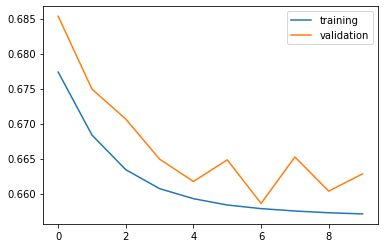

In [186]:
config['hidden_layers'] = [16]
loss_record_valid_16 = cross_validation(setting_2['x_train'], setting_2['y_train'], setting_2['x_valid'], setting_2['y_valid'], config)

[Info] epoch: 10/10 | training loss: 0.6566135883331299 | training recall: 0.555265546981389 | validation loss: 0.6624884009361267 | validation recall: 0.5376744186046511
[Info] Done


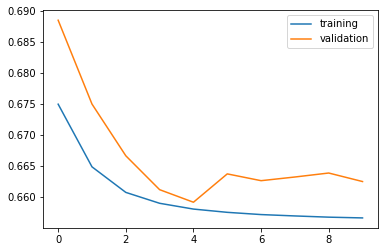

In [187]:
config['hidden_layers'] = [32]
loss_record_valid_32 = cross_validation(setting_2['x_train'], setting_2['y_train'], setting_2['x_valid'], setting_2['y_valid'], config)

[Info] epoch: 10/10 | training loss: 0.6564093232154846 | training recall: 0.5634362233318202 | validation loss: 0.6632622480392456 | validation recall: 0.5358139534883721
[Info] Done


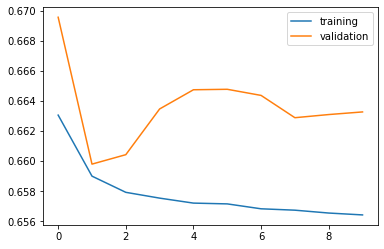

In [188]:
config['hidden_layers'] = [64]
loss_record_valid_64 = cross_validation(setting_2['x_train'], setting_2['y_train'], setting_2['x_valid'], setting_2['y_valid'], config)

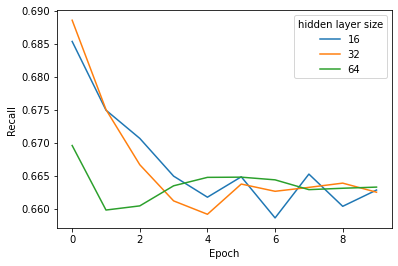

In [226]:
plt.plot(loss_record_valid_16, label='16')
plt.plot(loss_record_valid_32, label='32')
plt.plot(loss_record_valid_64, label='64')
plt.legend(title='hidden layer size')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.savefig('mlp_hidden_layer_size.png')
plt.show()

As the size of the hidden unit increases, the model overfits more, which makes sense. However, the training and validation accuracies both increase. There is a tradeoff between overfitting and accuracy.

### Impact of the number of hidden layers

[Info] epoch: 10/10 | training loss: 0.6570838689804077 | training recall: 0.5609396277802996 | validation loss: 0.6644085645675659 | validation recall: 0.5395348837209303
[Info] Done


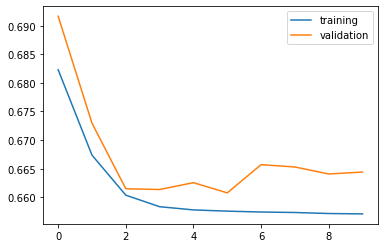

In [190]:
config['hidden_layers'] = [16] * 2
loss_record_valid_2 = cross_validation(setting_2['x_train'], setting_2['y_train'], setting_2['x_valid'], setting_2['y_valid'], config)

[Info] epoch: 10/10 | training loss: 0.6574762463569641 | training recall: 0.5325692237857467 | validation loss: 0.6472436189651489 | validation recall: 0.5097674418604651
[Info] Done


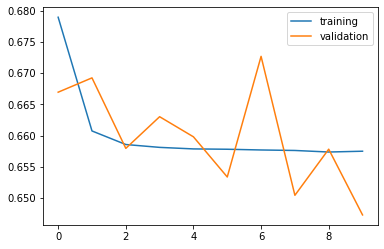

In [191]:
config['hidden_layers'] = [16] * 4
loss_record_valid_4 = cross_validation(setting_2['x_train'], setting_2['y_train'], setting_2['x_valid'], setting_2['y_valid'], config)

[Info] epoch: 10/10 | training loss: 0.6579025983810425 | training recall: 0.6238084430322288 | validation loss: 0.6859793663024902 | validation recall: 0.5934883720930233
[Info] Done


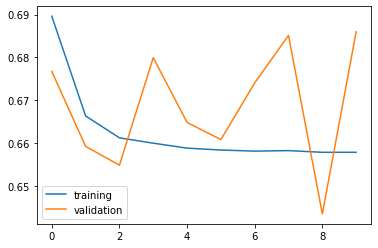

In [192]:
config['hidden_layers'] = [16] * 8
loss_record_valid_8 = cross_validation(setting_2['x_train'], setting_2['y_train'], setting_2['x_valid'], setting_2['y_valid'], config)

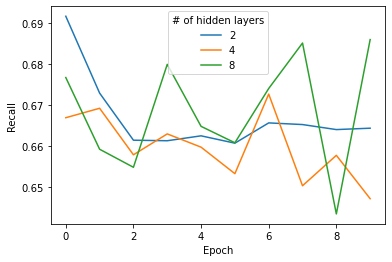

In [227]:
plt.plot(loss_record_valid_2, label='2')
plt.plot(loss_record_valid_4, label='4')
plt.plot(loss_record_valid_8, label='8')
plt.legend(title='# of hidden layers')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.savefig('mlp_number_of_hidden.png')
plt.show()

Having more layers helps the model to converge better but also increases the chance of overfitting. There is a tradeoff we need to make.

### Impact of the activation function (ReLU vs. Tanh)

[Info] epoch: 10/10 | training loss: 0.6576360464096069 | training recall: 0.5228098048116205 | validation loss: 0.6414229273796082 | validation recall: 0.5051162790697674
[Info] Done


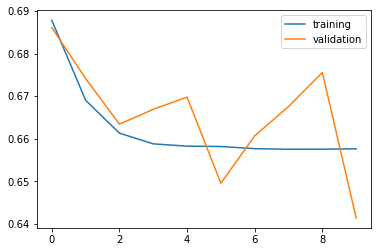

In [194]:
config['hidden_layers'] = [16] * 4
config['act'] = 'tanh'
loss_record_valid_tanh = cross_validation(setting_2['x_train'], setting_2['y_train'], setting_2['x_valid'], setting_2['y_valid'], config)

[Info] epoch: 10/10 | training loss: 0.6931472420692444 | training recall: 0.0 | validation loss: 0.6931472420692444 | validation recall: 0.0
[Info] Done


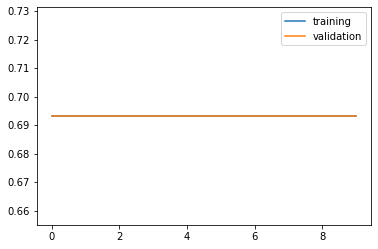

In [197]:
config['act'] = 'relu'
loss_record_valid_relu = cross_validation(setting_2['x_train'], setting_2['y_train'], setting_2['x_valid'], setting_2['y_valid'], config)

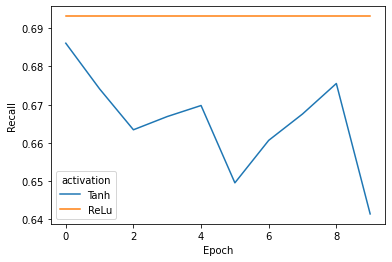

In [228]:
plt.plot(loss_record_valid_tanh, label='Tanh')
plt.plot(loss_record_valid_relu, label='ReLu')
plt.legend(title='activation')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.savefig('mlp_activation.png')
plt.show()

Tanh performs better in the above experiment. We will use Tanh from now on.

## Impact of Dropout layer

[Info] epoch: 10/10 | training loss: 0.672203004360199 | training recall: 0.5710394916023604 | validation loss: 0.6758553981781006 | validation recall: 0.5562790697674419
[Info] Done


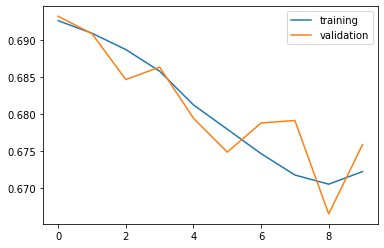

In [202]:
config['act'] = 'tanh'
config['with_do'] = True
loss_record_valid_do = cross_validation(setting_2['x_train'], setting_2['y_train'], setting_2['x_valid'], setting_2['y_valid'], config)

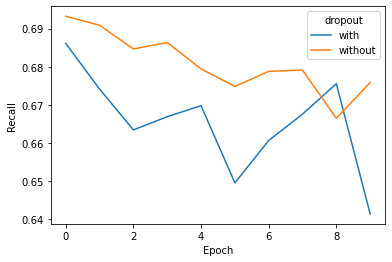

In [229]:
plt.plot(loss_record_valid_tanh, label='with')
plt.plot(loss_record_valid_do, label='without')
plt.legend(title='dropout')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.savefig('mlp_dropout.png')
plt.show()

As expected, dropout layer significantly reduces overfitting. I am going to keep it.

## Impact of BatchNorm

[Info] epoch: 10/10 | training loss: 0.6672947406768799 | training recall: 0.5728551974580118 | validation loss: 0.6657823324203491 | validation recall: 0.5562790697674419
[Info] Done


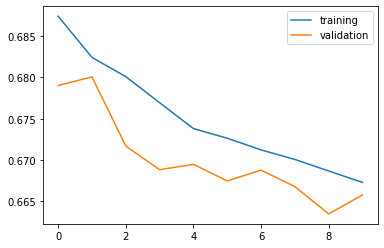

In [205]:
config['with_bn'] = True
loss_record_valid_bn = cross_validation(setting_2['x_train'], setting_2['y_train'], setting_2['x_valid'], setting_2['y_valid'], config)

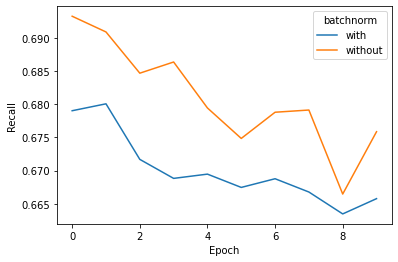

In [230]:
plt.plot(loss_record_valid_bn, label='with')
plt.plot(loss_record_valid_do, label='without')
plt.legend(title='batchnorm')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.savefig('mlp_batchnorm.png')
plt.show()

## Evaluate the best model on test data

In [214]:
best_config = dict(
    size_feature = size_feature,
    act = 'tanh',
    hidden_layers = [16] * 4,
    with_do = True,
    with_bn = True,
    batch_size = 512,
    num_epoch = 25,
    lr = 5e-4,
    decay = 1e-6,
)

[Info] epoch: 25/25 | training loss: 0.4268231987953186 | training recall: 0.021334543803903767 | validation loss: 0.43122777342796326 | validation recall: 0.011443661971830986
[Info] Done


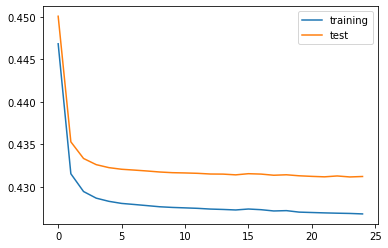

In [215]:
best_model = mlp.MLP(best_config['size_feature'], 1, best_config['hidden_layers'], best_config['act']).to(device)
loss_record_train, loss_record_valid = train(best_model, setting_1['x_train'], setting_1['y_train'], setting_1['x_test'], setting_1['y_test'], best_config)
plt.plot(loss_record_train, label='training')
plt.plot(loss_record_valid, label='test')
plt.legend()
plt.show()

In [216]:
best_model.eval()
yhat_test = torch.round(torch.sigmoid(best_model(setting_1['x_test'])))
yhat_test_ = yhat_test.detach().cpu().numpy()
y_test_ = setting_1['y_test'].cpu().numpy()
print(sklearn.metrics.classification_report(y_test_, yhat_test_))

              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94      8432
         1.0       0.57      0.01      0.02      1136

    accuracy                           0.88      9568
   macro avg       0.72      0.51      0.48      9568
weighted avg       0.84      0.88      0.83      9568



In [217]:
print(f'roc auc score: {sklearn.metrics.roc_auc_score(y_test_, yhat_test_)}')

roc auc score: 0.5051288518587808


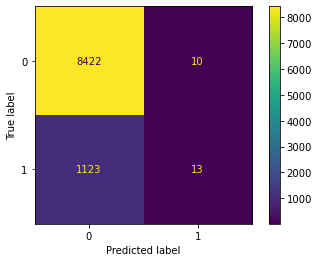

In [218]:
cm = sklearn.metrics.confusion_matrix(y_test_, yhat_test_)
cm_disp = sklearn.metrics.ConfusionMatrixDisplay(cm)
cm_disp.plot()
plt.savefig('cm_setting_1.png')
plt.show()

[Info] epoch: 25/25 | training loss: 0.6565521359443665 | training recall: 0.5750113481615978 | validation loss: 0.6644870638847351 | validation recall: 0.5730633802816901
[Info] Done


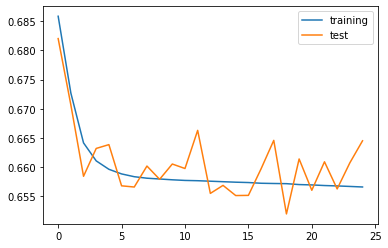

In [233]:
best_model = mlp.MLP(best_config['size_feature'], 1, best_config['hidden_layers'], best_config['act']).to(device)
loss_record_train, loss_record_valid = train(best_model, setting_2['x_train'], setting_2['y_train'], setting_2['x_test'], setting_2['y_test'], best_config)
plt.plot(loss_record_train, label='training')
plt.plot(loss_record_valid, label='test')
plt.legend()
plt.show()

In [234]:
best_model.eval()
yhat_test = torch.round(torch.sigmoid(best_model(setting_2['x_test'])))
yhat_test_ = yhat_test.detach().cpu().numpy()
y_test_ = setting_2['y_test'].cpu().numpy()
print(sklearn.metrics.classification_report(y_test_, yhat_test_))

              precision    recall  f1-score   support

         0.0       0.92      0.64      0.75      8432
         1.0       0.18      0.57      0.27      1136

    accuracy                           0.63      9568
   macro avg       0.55      0.61      0.51      9568
weighted avg       0.83      0.63      0.69      9568



In [221]:
print(f'roc auc score: {sklearn.metrics.roc_auc_score(y_test_, yhat_test_)}')

roc auc score: 0.6109455595050378


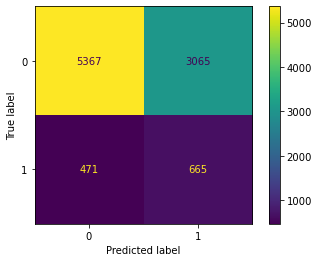

In [222]:
cm = sklearn.metrics.confusion_matrix(y_test_, yhat_test_)
cm_disp = sklearn.metrics.ConfusionMatrixDisplay(cm)
cm_disp.plot()
plt.savefig('cm_setting_2.png')
plt.show()

In [223]:
for i in range(5):
    best_model = mlp.MLP(best_config['size_feature'], 1, best_config['hidden_layers'], best_config['act']).to(device)
    train(best_model, setting_1['x_train'], setting_1['y_train'], setting_1['x_test'], setting_1['y_test'], best_config)

    best_model.eval()
    yhat_test = torch.round(torch.sigmoid(best_model(setting_1['x_test'])))
    yhat_test_ = yhat_test.detach().cpu().numpy()
    y_test_ = setting_1['y_test'].cpu().numpy()
    print(sklearn.metrics.classification_report(y_test_, yhat_test_))
    print(f'roc auc score: {sklearn.metrics.roc_auc_score(y_test_, yhat_test_)}')

[Info] epoch: 25/25 | training loss: 0.42688894271850586 | training recall: 0.02235587834770767 | validation loss: 0.4313201308250427 | validation recall: 0.013204225352112676
[Info] Done
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94      8432
         1.0       0.60      0.01      0.03      1136

    accuracy                           0.88      9568
   macro avg       0.74      0.51      0.48      9568
weighted avg       0.85      0.88      0.83      9568

roc auc score: 0.5060091335489216
[Info] epoch: 25/25 | training loss: 0.42656826972961426 | training recall: 0.02541988197911938 | validation loss: 0.4315545856952667 | validation recall: 0.01232394366197183
[Info] Done
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94      8432
         1.0       0.48      0.01      0.02      1136

    accuracy                           0.88      9568
   macro avg       0.68      0.51      0.48   

In [224]:
for i in range(5):
    best_model = mlp.MLP(best_config['size_feature'], 1, best_config['hidden_layers'], best_config['act']).to(device)
    train(best_model, setting_2['x_train'], setting_2['y_train'], setting_2['x_test'], setting_2['y_test'], best_config)

    best_model.eval()
    yhat_test = torch.round(torch.sigmoid(best_model(setting_2['x_test'])))
    yhat_test_ = yhat_test.detach().cpu().numpy()
    y_test_ = setting_2['y_test'].cpu().numpy()
    print(sklearn.metrics.classification_report(y_test_, yhat_test_))
    print(f'roc auc score: {sklearn.metrics.roc_auc_score(y_test_, yhat_test_)}')

[Info] epoch: 25/25 | training loss: 0.6563779711723328 | training recall: 0.562755333635951 | validation loss: 0.6572037935256958 | validation recall: 0.5651408450704225
[Info] Done
              precision    recall  f1-score   support

         0.0       0.92      0.65      0.76      8432
         1.0       0.18      0.57      0.27      1136

    accuracy                           0.64      9568
   macro avg       0.55      0.61      0.52      9568
weighted avg       0.83      0.64      0.70      9568

roc auc score: 0.6084717508084561
[Info] epoch: 25/25 | training loss: 0.6560574173927307 | training recall: 0.5635497049477984 | validation loss: 0.6567733883857727 | validation recall: 0.5730633802816901
[Info] Done
              precision    recall  f1-score   support

         0.0       0.92      0.65      0.76      8432
         1.0       0.18      0.57      0.27      1136

    accuracy                           0.64      9568
   macro avg       0.55      0.61      0.52      9568


In [211]:
y_test_ = y_test_.reshape(-1)
yhat_test_ = y_test_.reshape(-1)

In [235]:
import os
dir_pred = 'prediction'
os.makedirs(dir_pred, exist_ok=True)
np.savetxt(os.path.join(dir_pred, 'mlp_y_test.txt'), y_test_)
np.savetxt(os.path.join(dir_pred, 'mlp_yhat_test.txt'), yhat_test_)